In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.3 MB/s eta 0:00:00


In [3]:
import os
import numpy as np
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, Dense, Input
from keras.optimizers import RMSprop

# Load the dataset
#train_labels = pd.read_csv('labels/stage_2_train_labels.csv')
#detailed_class_info = pd.read_csv('labels/stage_2_detailed_class_info.csv')

detailed_class_info = pd.read_csv("/content/drive/MyDrive/PGDM_course/capstone_data/stage_2_detailed_class_info.csv")
train_labels = pd.read_csv("/content/drive/MyDrive/PGDM_course/capstone_data/stage_2_train_labels.csv")


In [4]:
# Merge the dataframes
merged_df = pd.merge(train_labels, detailed_class_info, on='patientId')
merged_df.head()

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


In [5]:
# Check for any missing values
print(merged_df.isnull().sum())

# Extract unique classes
classes = merged_df['class'].unique()
print(classes)


patientId        0
x            20672
y            20672
width        20672
height       20672
Target           0
class            0
dtype: int64
['No Lung Opacity / Not Normal' 'Normal' 'Lung Opacity']


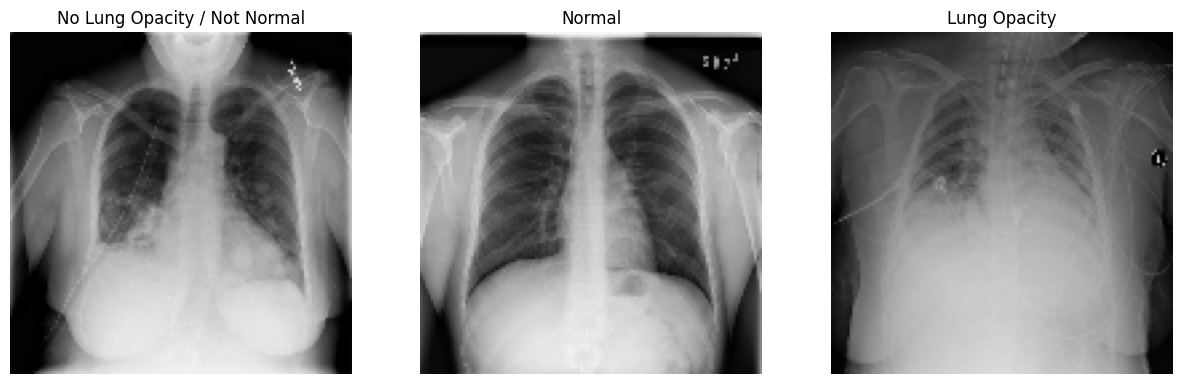

In [7]:
# Define a function to load and preprocess DICOM images
def load_dicom_image(patient_id, image_dir, target_size=(128, 128)):
    dcm_path = os.path.join(image_dir, patient_id + '.dcm')
    dcm_data = pydicom.read_file(dcm_path)
    img = dcm_data.pixel_array
    img = cv2.resize(img, target_size)
    img = np.stack((img,)*3, axis=-1)  # Convert to 3-channel image
    return img

# Plot some images with their classes
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
image_dir='/content/drive/MyDrive/PGDM_course/capstone_data/stage_2_train_images'
#image_dir = 'stage_2_train_images'

for i, cls in enumerate(classes):
    sample_id = merged_df[merged_df['class'] == cls].iloc[0]['patientId']
    img = load_dicom_image(sample_id, image_dir)
    ax[i].imshow(img, cmap='gray')
    ax[i].set_title(cls)
    ax[i].axis('off')

plt.show()


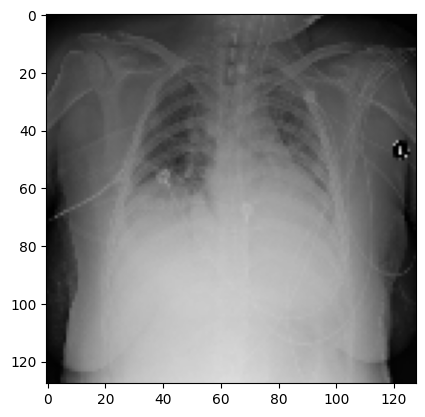

In [8]:
def plot_image_with_bbox(patient_id, image_dir, df):
    img = load_dicom_image(patient_id, image_dir)
    bboxes = df[df['patientId'] == patient_id][['x', 'y', 'width', 'height']].values

    fig, ax = plt.subplots(1)
    ax.imshow(img, cmap='gray')

    for bbox in bboxes:
        rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

sample_patient_id = merged_df[merged_df['Target'] == 1].iloc[0]['patientId']
plot_image_with_bbox(sample_patient_id, image_dir, merged_df)


In [11]:
# Data generator for augmentation
datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True, validation_split=0.2)

# Prepare data
X = np.array([load_dicom_image(pid, image_dir) for pid in merged_df['patientId']])


In [12]:
y = to_categorical(merged_df['Target'])


In [13]:

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


Epoch 1/10
753/753 [==============================] - 200s 264ms/step - loss: 1.4196 - accuracy: 0.5443 - val_loss: 0.6870 - val_accuracy: 0.5693
Epoch 2/10
753/753 [==============================] - 197s 262ms/step - loss: 0.6771 - accuracy: 0.5746 - val_loss: 0.6872 - val_accuracy: 0.5550
Epoch 3/10
753/753 [==============================] - 197s 262ms/step - loss: 0.6657 - accuracy: 0.5934 - val_loss: 0.6587 - val_accuracy: 0.6317
Epoch 4/10
753/753 [==============================] - 198s 263ms/step - loss: 0.6492 - accuracy: 0.6216 - val_loss: 0.6260 - val_accuracy: 0.6701
Epoch 5/10
753/753 [==============================] - 197s 262ms/step - loss: 0.6361 - accuracy: 0.6474 - val_loss: 0.6502 - val_accuracy: 0.6309
Epoch 6/10
753/753 [==============================] - 197s 262ms/step - loss: 0.6300 - accuracy: 0.6539 - val_loss: 0.6116 - val_accuracy: 0.6869
Epoch 7/10
753/753 [==============================] - 197s 262ms/step - loss: 0.6276 - accuracy: 0.6613 - val_loss: 0.6350 -

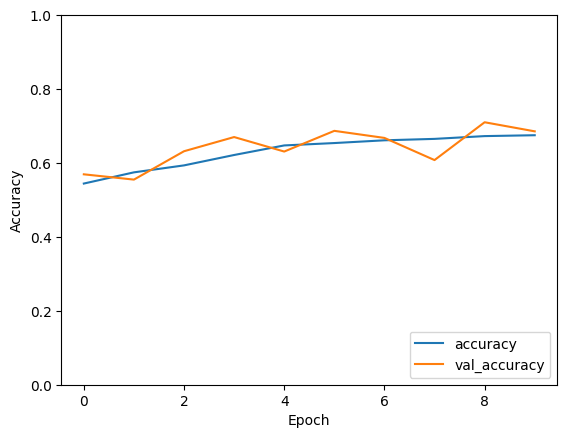

In [14]:

# Define a basic CNN model
def basic_cnn_model(height, width, num_channels, num_classes):
    model = Sequential()
    model.add(Input(shape=(height, width, num_channels)))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(GlobalMaxPooling2D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create the model
model = basic_cnn_model(128, 128, 3, 2)

# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32, subset='training'),
                    validation_data=datagen.flow(X_train, y_train, batch_size=32, subset='validation'),
                    epochs=10, verbose=1)

# Evaluate the model
score = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation accuracy: {score[1]}")

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()
